In [45]:
# Load Dataset
import kagglehub
import pandas as pd
import os
path = kagglehub.dataset_download("marshalpatel3558/diabetes-prediction-dataset-legit-dataset")
print("Path to dataset files:", path)
csv_file = os.path.join(path, os.listdir(path)[0])
df = pd.read_csv(csv_file)
print(df.head())

Path to dataset files: /kaggle/input/diabetes-prediction-dataset-legit-dataset
    ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI CLASS  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N  


In [46]:

from sklearn.preprocessing import LabelEncoder
df['CLASS'] = df['CLASS'].str.replace(' ', '', regex=False).str.lower()
df['Gender'] = df['Gender'].str.replace(' ', '', regex=False).str.lower()
le = LabelEncoder()
df['CLASS']= le.fit_transform(df['CLASS'])
df['Gender'] = le.fit_transform(df['Gender'])



both of these columns were in string format, so it was necessary to encode them. Before that could happen, they had to get cleaned. I removed all spaces from the columns and converted them to lowercase so then that way, rows with the same letter but having a space in the string are the same and not different values when they are encoded.
 Class is the target variable, which is a classification of whether the patient has diabetes, does not, or is borderline. This classification is ordinal. Because of the ordered nature, label encoder is better.
For Gender which is a feature, although there is no inherent order, there are only two genders, so there is no need for one hot encoding.

In [47]:
df_features = df.drop(['CLASS'], axis=1)
df_target = df['CLASS']


creating the features and target

In [48]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=42)



we are trying LightGBM first

In [49]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 13
[LightGBM] [Info] Start training from score -2.277892
[LightGBM] [Info] Start training from score -2.834464
[LightGBM] [Info] Start training from score -0.175843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

LGBMClassifier()

In [50]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.985
Confusion Matrix:
 [[ 19   2   0]
 [  0   6   0]
 [  1   0 172]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.75      1.00      0.86         6
           2       1.00      0.99      1.00       173

    accuracy                           0.98       200
   macro avg       0.90      0.97      0.93       200
weighted avg       0.99      0.98      0.99       200



model was mostly accurate overall. For class 1, which are the borderline non-diabetics, only 75% of the ones it predicted where in this category truly belonged here, but other than that, that was the only low accuracy metric. The rest all had pretty high precision and recalls. For class 2, which are the diabetic patients, the model had a perfect precision score meaning that of the patients it predicted were diabetic, every single one of them were. Overall, the model did really well.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.20, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.995
Confusion Matrix:
 [[ 21   0   0]
 [  0   6   0]
 [  1   0 172]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      1.00      1.00         6
           2       1.00      0.99      1.00       173

    accuracy                           0.99       200
   macro avg       0.98      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



random forest is being tried here. It got a slightly better accuracy of 99.5%. The model had no weaknesses and the lowest subscore was precision for the non-diabetics, predicting that of the patients it predicted were non diabetic, 95% of them belonged in that category. In sum, the random forest model was near perfect.

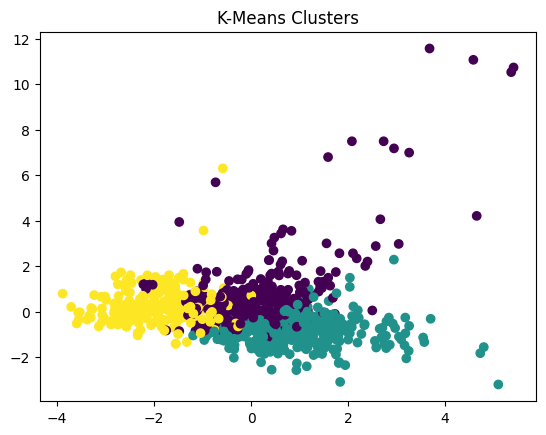

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)


kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)


df_features['Cluster'] = clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters)
plt.title("K-Means Clusters")
plt.show()




towards the right on PC1 is unhealthier and to the left is healthier. The yellow is the unhealthiest while the purple is the healthiest, but the healthiest have all sorts of variation though in how healthy they are. the distribution of each point in the clusters does not necesarily match the distribition of how diabetic patients are. Majority in the dataset were diabetic, but there were different levels of unhealthiness among the diabetics. A group of patients was more unhealthy than another group of diabetic patients that two different clusters of diabetic patients formed. As you move further to the left, there is higher variation in this group, which indicates a wide range of health conditions where individuals were unhealthy in diverse areas but were overall healthy.

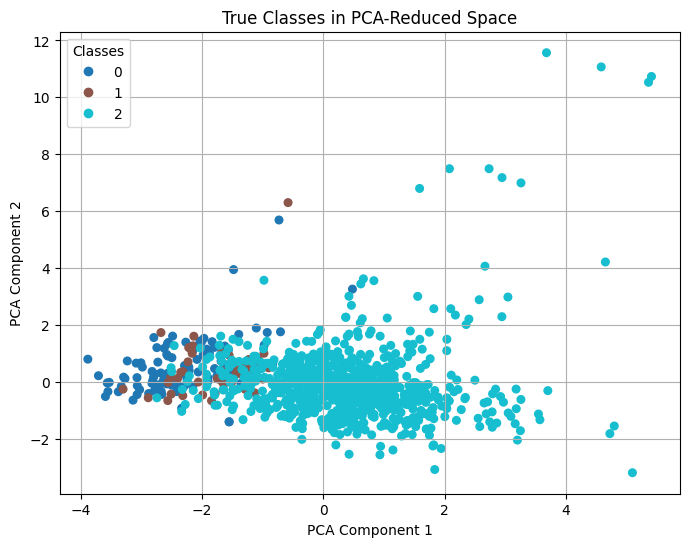

In [53]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c= df_target, cmap='tab10', s=30)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("True Classes in PCA-Reduced Space")
plt.grid(True)
plt.show()



This visual is a PCA compression but each color coding is the class of diabetes. 0 is no diabetes, 1 is borderline, and 2 is diabetic. We can see that all of the non diabetics are located towards the left, and the diabetic groups are towards the right. There is an area of strong overlap with the borderline non diabetics where many of their plots are clustered near to where the healthier end of the diabetics are.